In [1]:
import joblib
import os
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

# 1. Cargar los datos que guardamos antes
data_path = r"D:\UTP\Empresa Aeronáutica\aerosafe-risk-predictor\data\processed\model_data.pkl"
X_train, X_test, y_train, y_test = joblib.load(data_path)

# 2. Configurar el modelo
# Usamos class_weight='balanced' porque hay pocos casos de daño comparado con los de no daño
model_rf = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42)

# 3. Entrenar el modelo (esto puede tardar unos segundos)
print("Entrenando el modelo Random Forest...")
model_rf.fit(X_train, y_train)

# 4. Realizar predicciones
y_pred = model_rf.predict(X_test)

# 5. Ver resultados
print("\n=== Reporte de Clasificación ===")
print(classification_report(y_test, y_pred))

print("\nROC-AUC Score:", roc_auc_score(y_test, model_rf.predict_proba(X_test)[:, 1]))

Entrenando el modelo Random Forest...

=== Reporte de Clasificación ===
              precision    recall  f1-score   support

           0       0.92      0.97      0.94      4595
           1       0.43      0.25      0.31       491

    accuracy                           0.90      5086
   macro avg       0.68      0.61      0.63      5086
weighted avg       0.88      0.90      0.88      5086


ROC-AUC Score: 0.7728401764957483


In [2]:
import joblib
import os

models_dir = r"D:\UTP\Empresa Aeronáutica\aerosafe-risk-predictor\data\processed"
os.makedirs(models_dir, exist_ok=True)

joblib.dump(model_rf, os.path.join(models_dir, "rf_damage_model.pkl"))
print("Modelo Random Forest guardado en data/processed/rf_damage_model.pkl")

Modelo Random Forest guardado en data/processed/rf_damage_model.pkl


In [3]:
import pandas as pd
import joblib
import numpy as np

# Cargar preprocesador y modelo
processed_dir = r"D:\UTP\Empresa Aeronáutica\aerosafe-risk-predictor\data\processed"
preprocessor = joblib.load(os.path.join(processed_dir, "preprocessor_ohe.pkl"))
model_rf = joblib.load(os.path.join(processed_dir, "rf_damage_model.pkl"))

def predecir_daño(registro_dict):
    """
    registro_dict: diccionario con las mismas claves que X:
        AircraftType, AirportName, AltitudeBin, MakeModel,
        WildlifeSize, ConditionsSky, ConditionsPrecipitation
    """
    df_nuevo = pd.DataFrame([registro_dict])
    X_enc = preprocessor.transform(df_nuevo)
    prob_daño = model_rf.predict_proba(X_enc)[0, 1]
    pred = int(prob_daño >= 0.5)
    return pred, prob_daño

# Ejemplo de uso
ejemplo = {
    "AircraftType": "Airplane",
    "AirportName": "DALLAS/FORT WORTH INTL ARPT",
    "AltitudeBin": "(1000, 2000]",
    "MakeModel": "B-737-400",
    "WildlifeSize": "Medium",
    "ConditionsSky": "No Cloud",
    "ConditionsPrecipitation": "Unknown"
}

pred, prob = predecir_daño(ejemplo)
print("Predicción (1=Caused damage, 0=No damage):", pred)
print("Probabilidad de daño:", prob)

Predicción (1=Caused damage, 0=No damage): 0
Probabilidad de daño: 0.1777330015797832


In [1]:
# CELDA 1: Imports
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# CELDA 2: Cargar dataset procesado
clean_path = r"D:\UTP\AeroCVer\aerosafe-risk-predictor\data\processed\bird_strikes_clean.csv"

df = pd.read_csv(clean_path)
df.head()

,AircraftType,AirportName,AltitudeBin,MakeModel,WildlifeSize,ConditionsSky,PilotWarned,FlightPhase,Month,Year,IsSevere
0,Airplane,LAGUARDIA NY,"(1000, 2000]",B-737-400,Medium,No Cloud,N,Climb,11,2000,1
1,Airplane,DALLAS/FORT WORTH INTL ARPT,"(-1, 0]",MD-80,Small,Some Cloud,Y,Landing Roll,7,2001,1
2,Airplane,LAKEFRONT AIRPORT,"(30, 50]",C-500,Small,No Cloud,N,Approach,9,2001,0
3,Airplane,SEATTLE-TACOMA INTL,"(30, 50]",B-737-400,Small,Some Cloud,Y,Climb,9,2002,0
4,Airplane,NORFOLK INTL,"(30, 50]",CL-RJ100/200,Small,No Cloud,N,Approach,6,2003,0


In [3]:
# CELDA 3: Definir X (features) e y (target)
X = df.drop(columns=['IsSevere'])
y = df['IsSevere']

# Identificar columnas categóricas y numéricas
cat_cols = X.select_dtypes(include=['object']).columns.tolist()
num_cols = X.select_dtypes(exclude=['object']).columns.tolist()

cat_cols, num_cols

(['AircraftType',
  'AirportName',
  'AltitudeBin',
  'MakeModel',
  'WildlifeSize',
  'ConditionsSky',
  'PilotWarned',
  'FlightPhase'],
 ['Month', 'Year'])

In [4]:
# CELDA 4: División de datos y Pipeline de preprocesamiento
# Dividir en 80% entrenamiento y 20% prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Definir cómo transformar las columnas
# handle_unknown='ignore' es vital porque puede haber aeropuertos nuevos en el test
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), cat_cols),
        ('num', 'passthrough', num_cols)
    ])

print(f"Datos divididos: {X_train.shape[0]} muestras para entrenar y {X_test.shape[0]} para probar.")

Datos divididos: 20343 muestras para entrenar y 5086 para probar.


In [5]:
# CELDA 5: Crear y entrenar el Pipeline con el modelo
model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced'))
])

# Entrenar (esto puede tardar unos segundos)
model_pipeline.fit(X_train, y_train)
print("¡Modelo entrenado con éxito!")

¡Modelo entrenado con éxito!


--- Reporte de Clasificación ---
              precision    recall  f1-score   support

           0       0.92      0.98      0.95      4595
           1       0.56      0.19      0.28       491

    accuracy                           0.91      5086
   macro avg       0.74      0.58      0.61      5086
weighted avg       0.88      0.91      0.89      5086



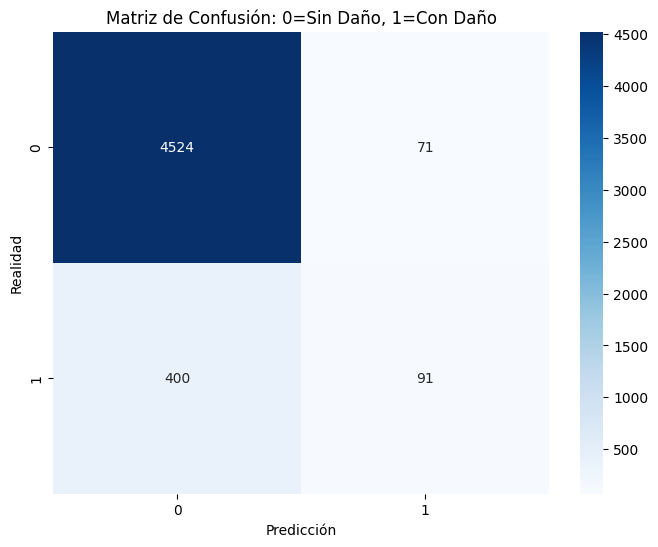

In [6]:
# CELDA 6: Evaluación del modelo
y_pred = model_pipeline.predict(X_test)

print("--- Reporte de Clasificación ---")
print(classification_report(y_test, y_pred))

# Matriz de Confusión visual
plt.figure(figsize=(8,6))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicción')
plt.ylabel('Realidad')
plt.title('Matriz de Confusión: 0=Sin Daño, 1=Con Daño')
plt.show()

## 5. Conclusiones del modelo de clasificación básica

- Se entrenó un modelo `RandomForestClassifier` usando variables operacionales
  (tipo de aeronave, aeropuerto, fase de vuelo, condiciones del cielo, etc.).
- El dataset está desbalanceado: los casos con `IsSevere = 1` (daño) son minoría.
- El modelo obtiene:
  - Muy buen desempeño para la clase 0 (sin daño), con F1 ≈ 0.95.
  - Desempeño limitado para la clase 1 (con daño), con F1 ≈ 0.28 y recall ≈ 0.19.
- En la matriz de confusión se observa que el modelo:
  - Acertó 4524 casos sin daño.
  - Solo identificó correctamente 91 incidentes con daño.
  - Dejó escapar 400 incidentes con daño (falsos negativos), lo cual es crítico en seguridad.
- Este modelo sirve como línea base. Próximos pasos:
  - Probar técnicas de balanceo (por ejemplo, `class_weight`, sobremuestreo de la clase 1).
  - Ajustar el umbral de probabilidad para priorizar el recall en la clase 1.
  - Explorar otros modelos (Logistic Regression, XGBoost, etc.) y comparar.